In [1]:
import torch

import torch.nn as nn 
from torchvision import datasets, transforms, models

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import io
import requests
import time

In [2]:
device = "cpu" # I'm not sure if it will work out of the box with cuda even if you have a GPU
torch.cuda.is_available()

False

Currently, CUDA support on macOS is only available by [building PyTorch from source](https://pytorch.org/get-started/locally/#mac-from-source)

# Define some attacks

## FGSM

[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)

Move image towards (or away from) given label by following graident; but always move distance given by *epsilon*.

In [3]:
def __fgsm(model, x, label, epsilon, targeted, clamp):
    model.zero_grad()

    x = torch.as_tensor(x, device=device)
    x.requires_grad = True
    
    logits = model(x)
    target = torch.LongTensor([label]).to(device)
    loss = nn.CrossEntropyLoss()(logits, target)
    loss.backward()
    
    diff = epsilon * x.grad.sign()
    
    if targeted:
        adv = x - diff
    else:
        adv = x + diff
    
    return adv.clamp(0, 1) if clamp else adv

def fgsm_targeted(model, x, label, epsilon, clamp=True):
    """
    model = neural network with logits output (not softmax)
    x = image 
    label = target label (don't care about the true label)
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, True, clamp)
    
def fgsm_untargeted(model, x, label, epsilon, clamp=True):    
    """
    model = neural network with logits output (not softmax)
    x = image
    label = the true label
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, False, clamp)

## PGD - Projected Gradient Descent

[Towards Evaluating the Robustness of Neural Networks](https://arxiv.org/abs/1608.04644)

Simply iterated FGSM

In [4]:
def __pgd(model, x, label, k, epsilon, epsilon_step, targeted, clamp):
    x = torch.as_tensor(x, device=device)
    
    x_min = x - epsilon
    x_max = x + epsilon
    
    for i in range(k):
        x = __fgsm(model, x.detach(), label, epsilon_step, targeted, clamp)  
        x = torch.max(x_min, x)
        x = torch.min(x_max, x)
    
    return x

def pgd_targeted(model, x, target, k, epsilon, epsilon_step, clamp=False):
    """
    model = neural network (with logits as output - not probs)
    x = image
    label = target
    k = number of iterations 
    epsilon = maximum allowed distance between input and output in infinity norm
    epsilon_step = distance in infinity norm moved each iteration
    clamp = bool; limit output channels to the interval [0,1]
    """
    return __pgd(model, x, target, k, epsilon, epsilon_step, True, clamp)

def pgd_untargeted(model, x, label, k, epsilon, epsilon_step, clamp=False):
    """
    model = neural network (with logits as output - not probs)
    x = image
    label = true label
    k = number of iterations 
    epsilon = maximum allowed distance between input and output in infinity norm
    epsilon_step = distance in infinity norm moved each iteration
    clamp = bool; limit output channels to the interval [0,1]
    """
    return __pgd(model, x, label, k, epsilon, epsilon_step, False, clamp)


# Find and prepare an image

In [5]:
IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg'
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json' # VGG Class labels

response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))  

response = requests.get(LABELS_URL) 
labels = {int(key): value for key, value in response.json().items()}

In [6]:
min_img_size = 224

pre_transform = transforms.Compose([
    transforms.Resize(min_img_size),
    #transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.RandomRotation(32)
])

img = pre_transform(img)
original = transforms.ToTensor()(img).to(device)[None,] # [None,] iom att pytorch vill ha [batch x img]

## Nice plotter

In [7]:
def plotter(image, adverserial, full_model):
    """Show the original (img), adversarial attack (adv), and some more stuff. Pass images as pytorch tensors"""
    image = image.cpu().detach()
    adverserial = adverserial.cpu().detach()
    
    probability_original = full_model(image.to(device)).cpu().detach().numpy()
    origial_image = image.numpy()[0]
    
    probability_adverserial = full_model(adverserial.to(device)).cpu().detach().numpy()
    adverserial_image = adverserial.numpy()[0]
    
    f, axes = plt.subplots(1,3, figsize=(15, 6))
    
    ax = axes[0]
    prediction = probability_original.argmax()
    ax.set_title("Original, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_original[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(origial_image, (1,2,0)))
    
    ax = axes[1]
    prediction = probability_adverserial.argmax()
    ax.set_title("Adverserial, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_adverserial[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(adverserial_image, (1,2,0)))
    
    ax = axes[2]
    diff = np.transpose(adverserial_image - origial_image, (1,2,0))
    plt.imshow(diff + 0.5)
    plt.show()

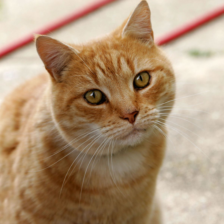

In [8]:
img

# Load a model

I am not training a model here... I don't know if we should do that

In [ ]:
model = models.vgg16(pretrained=True)
full_model = nn.Sequential(model, nn.Softmax(dim=1)).to(device).eval()

In [ ]:
def predict(net, image, list_len=5, labels=labels):
    prediction = net(image)
    
    top_probs, top_labels = torch.topk(prediction, k=list_len, dim=1)
    
    max_len = max([len(labels[top_labels[0][i].item()]) for i in range(list_len)])
    base = "P[ {: <" + str(max_len) + "} ] = {:.3f}"
    for i in range(list_len):
        formatted = base.format(labels[top_labels[0][i].item()], top_probs[0][i].item()) 
        if i == 0:
            formatted = '\033[1m{}\033[0m'.format(formatted) 
        print(formatted)

# Testing classification of image

In [ ]:
predict(full_model, original)

P[ Egyptian cat    ] = 0.264
P[ plastic bag     ] = 0.179
P[ carton          ] = 0.160
P[ tiger cat       ] = 0.083
P[ lynx, catamount ] = 0.070


In [ ]:
original_class = model(original).detach().cpu().numpy().argmax()
original_class, labels[original_class]

(285, 'Egyptian cat')

# Testing the attacks

## Untargeted

### FGSM

This took 0.6s


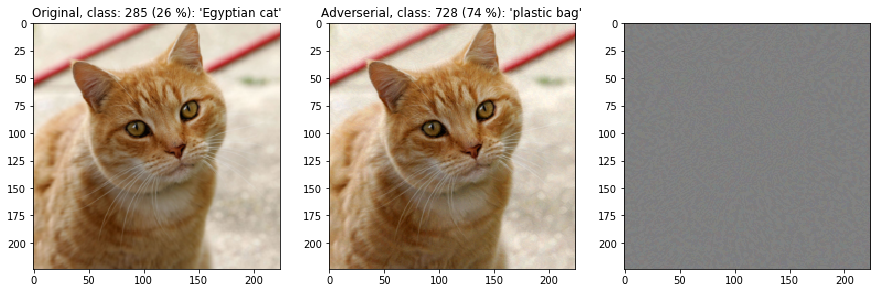

In [ ]:
t = time.time()

adv = fgsm_untargeted(model, original, label=original_class, epsilon=0.01, clamp=True)

print("This took {:.1f}s".format(time.time() - t))
plotter(original, adv, full_model)

### PGD

In [ ]:
t = time.time()

adv = pgd_untargeted(model, original, label=original_class, k=10, epsilon=0.01, epsilon_step=0.001, clamp=True)

print("This took {:.1f}s".format(time.time() - t))
plotter(original, adv, full_model)

## Targeted

In [ ]:
target = 79
target, labels[target]

### FGSM

In [ ]:
t = time.time()

adv = fgsm_targeted(model, original, label=target, epsilon=0.01)

print("This took {:.1f}s".format(time.time() - t))
plotter(original, adv, full_model

"Our $L_0$ attack is the first published attack that can cause targeted misclassification
on the ImageNet dataset." [Towards Evaluating the Robustness of Neural Networks]

### PGD

In [ ]:
t = time.time()

adv = pgd_targeted(model, original, target=target, k=10, epsilon=0.01, epsilon_step=0.005, clamp=True)

print("This took {:.1f}s".format(time.time() - t))
plotter(original, adv, full_model)

## Targeting the least probable class

In [ ]:
predictions = full_model(original).detach().cpu().numpy()
least_probale = predictions.argmin()
target = least_probale
target, labels[target], "{:.2e} %".format(100*predictions[0, least_probale])

In [ ]:
t = time.time()

adv = pgd_targeted(model, original, target=target, k=10, epsilon=0.01, epsilon_step=0.005, clamp=True)

print("This took {:.1f}s".format(time.time() - t))
plotter(original, adv, full_model)

Epsilon 0.01 is no longer enough!

In [ ]:
t = time.time()

adv = pgd_targeted(model, original, target=target, k=10, epsilon=0.05, epsilon_step=0.01, clamp=True)

print("This took {:.1f}s".format(time.time() - t))
plotter(original, adv, full_model)